Références : Puterman, M. L., Shin, M. C. (1978). Modified policy iteration algorithms for discounted Markov decision problems. Management Science, 24(11):1127–1137.

In [ ]:
# Installs the necessary Python and system libraries
try:
    from easypip import easyimport, easyinstall, is_notebook
except ModuleNotFoundError as e:
    get_ipython().run_line_magic("pip", "install 'easypip>=1.2.0'")
    from easypip import easyimport, easyinstall, is_notebook

easyinstall("bbrl>=0.1.14")
easyinstall("swig")
easyinstall("bbrl_gymnasium>=0.1.3")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")

from moviepy.editor import ipython_display as video_display

[easypip] Installing bbrl>=0.1.14
[easypip] Installing swig
[easypip] Installing bbrl_gymnasium>=0.1.3
[easypip] Installing box2d-kengz


In [ ]:
import os
from typing import Tuple, List

import numpy as np
if is_notebook():
    get_ipython().run_line_magic("matplotlib", "inline")
import matplotlib.pyplot as plt

easyimport("bbrl_gymnasium")
easyimport("moviepy")
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv

# For visualization
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

Matplotlib backend: module://matplotlib_inline.backend_inline


In [ ]:
import gymnasium as gym
import bbrl_gymnasium

  logger.warn(

  logger.warn(



Output()

# True Modified Policy Iteration

In [ ]:
def get_policy_from_v(mdp: MazeMDPEnv, v: np.ndarray) -> np.ndarray:
    # Outputs a policy given the state values
    policy = np.zeros(mdp.nb_states)  # initial state values are set to 0
    for x in range(mdp.nb_states-1):  # for each state x
        if x in mdp.terminal_states:
            policy[x] = np.argmax(mdp.r[x, :])
        else:
            # Compute the value of the state x for each action u of the MDP action space
            v_temp = []
            for u in range(mdp.action_space.n):
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ = summ + mdp.P[x, u, y] * v[y]
                v_temp.append(mdp.r[x, u] + mdp.gamma * summ)
            policy[x] = np.argmax(v_temp)
    return policy

In [ ]:
def improve_policy_from_v(mdp: MazeMDPEnv, v: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Improves a policy given the state values
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x in mdp.terminal_states:
            policy[x] = np.argmax(mdp.r[x, :])
        else:
            v_temp = np.zeros(mdp.action_space.n)
            for u in range(mdp.action_space.n):
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ = summ + mdp.P[x, u, y] * v[y]
                v_temp[u] = mdp.r[x, u] + mdp.gamma * summ

            for u in range(mdp.action_space.n):
                if v_temp[u] > v_temp[policy[x]]:
                    policy[x] = u
    return policy

In [ ]:
def evaluate_one_step_v(mdp: MazeMDPEnv, v: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    # Corresponds to one application of the Bellman Operator
    v_new = np.zeros(mdp.nb_states)  # initial state values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x in mdp.terminal_states:
            v_new[x] = mdp.r[x, policy[x]]
        else:
            # Process sum of the values of the neighbouring states
            summ = 0
            for y in range(mdp.nb_states):
                summ = summ + mdp.P[x, policy[x], y] * v[y]
            v_new[x] = mdp.r[x, policy[x]] + mdp.gamma * summ
    return v_new

In [ ]:
def evaluate_v(mdp: MazeMDPEnv, policy: np.ndarray, num_iterations: int) -> np.ndarray:
    # Outputs the state value function of a policy
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    for i in range(num_iterations):
        v = evaluate_one_step_v(mdp, v, policy)
    return v

In [ ]:
def evaluate_v_vanilla(mdp: MazeMDPEnv, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function of a policy
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    stop = False
    iters = 0
    while not stop:
        vold = v.copy()
        v = evaluate_one_step_v(mdp, vold, policy)

        iters += 1

        # Test if convergence has been reached
        if (np.linalg.norm(v - vold)) < 0.01:
            stop = True
    return v, iters

In [ ]:
from tabularmazemdp import random_policy
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder

In [ ]:
def modified_policy_iteration_v(mdp: MazeMDPEnv, render: bool = True, nb_critic_updates: int = 1, nb_iterations: int = 1) -> Tuple[np.ndarray, List[float]]:
    # policy iteration over the v function
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    policy = random_policy(mdp)

    stop = False

    # video_recorder = VideoRecorder(mdp, "videos/PolicyIterationV.mp4", enabled=render)
    # mdp.init_draw("Policy Iteration (V)", recorder=video_recorder)

    for i in range(nb_iterations):
        vold = v.copy()

        # mdp.draw_v(v, title="Policy iteration Q", recorder=video_recorder)

        # Step 1 : Policy Evaluation
        v = evaluate_v(mdp, policy, nb_critic_updates)

        # Step 2 : Policy Improvement
        policy = improve_policy_from_v(mdp, v, policy)

    # mdp.draw_v_pi(v, get_policy_from_v(mdp, v), recorder=video_recorder)
    # video_recorder.close()

    return v, v_list

In [ ]:
# ---------------- Policy Iteration with the V function -----------------#
# Given an MDP, this algorithm simultaneously computes
# the optimal state value function V and the optimal policy

def policy_iteration_v(mdp: MazeMDPEnv, render: bool = True, nb_iterations: int = 1) -> Tuple[np.ndarray, List[float], int, int]:
    # policy iteration over the v function
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    policy = random_policy(mdp)

    nb_iter = 0


    # video_recorder = VideoRecorder(mdp, "videos/PolicyIterationV.mp4", enabled=render)
    # mdp.init_draw("Policy Iteration (V)", recorder=video_recorder)

    for i in range(nb_iterations):
        vold = v.copy()

        # mdp.draw_v(v, title="Policy iteration Q", recorder=video_recorder)

        # Step 1 : Policy Evaluation
        # To be completed...

        v, k_vanilla = evaluate_v_vanilla(mdp, policy)


        # Step 2 : Policy Improvement
        # To be completed...

        policy = improve_policy_from_v(mdp, v, policy)


    # mdp.draw_v_pi(v, get_policy_from_v(mdp, v), recorder=video_recorder)
    # video_recorder.close()

    return v, v_list, k_vanilla

In [ ]:
import time
from typing import Dict

def empirical_study(mazes: List[MazeMDPEnv], nb_iters_max: int = 1):
    results_mpi = {}
    results_vanilla = {}

    opt_k = {}
    times_per_iter = {}
    scores = {}

    for nb_iter in range(1, nb_iters_max+1):
        nb_maze = 0
        for maze in mazes:
            k = 0
            if nb_maze not in opt_k:
                opt_k[nb_maze] = {}
                times_per_iter[nb_maze] = {}
                scores[nb_maze] = {}
            start_time = time.time()
            v, v_list = modified_policy_iteration_v(maze, nb_critic_updates=k, nb_iterations=nb_iter)
            end_time = time.time()

            while 0 in v:
                vold = v.copy()
                k += 1
                start_time = time.time()
                v, v_list = modified_policy_iteration_v(maze, nb_critic_updates=k, nb_iterations=nb_iter)
                end_time = time.time()

                if np.linalg.norm(vold - v) < 0.01:
                    opt_k[nb_maze][nb_iter] = k
                    times_per_iter[nb_maze][nb_iter] = end_time - start_time
                    scores[nb_maze][nb_iter] = v.sum()
                    break

            if np.linalg.norm(vold - v) < 0.01 and 0 not in v:
                opt_k[nb_maze][nb_iter] = k
                times_per_iter[nb_maze][nb_iter] = end_time - start_time
                scores[nb_maze][nb_iter] = v.sum()

            nb_maze += 1


    results_mpi = {
        'opt_k': opt_k,
        'times_per_iter': times_per_iter,
        'scores': scores
    }



    opt_k_vanilla = {}
    times_per_iter_vanilla = {}
    scores_vanilla = {}
    for nb_iter in range(1, nb_iters_max+1):
        nb_maze = 0
        for maze in mazes:
            if nb_maze not in opt_k_vanilla:
                opt_k_vanilla[nb_maze] = {}
                times_per_iter_vanilla[nb_maze] = {}
                scores_vanilla[nb_maze] = {}
            start_time = time.time()
            v, v_list, k_opt = policy_iteration_v(maze, nb_iter)
            end_time = time.time()

            opt_k_vanilla[nb_maze][nb_iter] = k_opt
            times_per_iter_vanilla[nb_maze][nb_iter] = end_time - start_time
            scores_vanilla[nb_maze][nb_iter] = v.sum()

            nb_maze += 1


    results_vanilla = {
        'opt_k': opt_k_vanilla,
        'times_per_iter': times_per_iter_vanilla,
        'scores': scores_vanilla
    }

    return results_mpi, results_vanilla

mazes = [gym.make("MazeMDP-v0", kwargs={"width": 10, "height": 10, "ratio": 0.1},render_mode="rgb_array") for _ in range(5)]
for i in range(len(mazes)):
  mazes[i].metadata['render_fps'] = 1
  mazes[i].reset()

  # in dynamic programming, there is no agent moving in the environment
  mazes[i].set_no_agent()

results_mpi, results_vanilla = empirical_study(mazes, 2)
print(results_mpi, results_vanilla)

{'opt_k': {0: {1: 9, 2: 11}, 1: {1: 6, 2: 17}, 2: {1: 11, 2: 38}, 3: {1: 2, 2: 5}, 4: {1: 2, 2: 5}}, 'times_per_iter': {0: {1: 0.7312240600585938, 2: 1.7369999885559082}, 1: {1: 0.5637476444244385, 2: 3.458325147628784}, 2: {1: 0.8603801727294922, 2: 5.862450122833252}, 3: {1: 0.34083032608032227, 2: 1.0291569232940674}, 4: {1: 0.34743261337280273, 2: 1.4655930995941162}}, 'scores': {0: {1: 1.0, 2: 3.61}, 1: {1: 1.0, 2: 3.61}, 2: {1: 1.0, 2: 2.8}, 3: {1: 1.0, 2: 2.8}, 4: {1: 1.0, 2: 2.8}}} {'opt_k': {0: {1: 2, 2: 3}, 1: {1: 3, 2: 4}, 2: {1: 2, 2: 3}, 3: {1: 2, 2: 2}, 4: {1: 2, 2: 3}}, 'times_per_iter': {0: {1: 0.3444054126739502, 2: 0.396012544631958}, 1: {1: 0.4015026092529297, 2: 0.4590423107147217}, 2: {1: 0.33443355560302734, 2: 0.3924129009246826}, 3: {1: 0.35137391090393066, 2: 0.34935665130615234}, 4: {1: 0.33089590072631836, 2: 0.3944664001464844}}, 'scores': {0: {1: 1.0, 2: 1.9}, 1: {1: 1.9, 2: 2.71}, 2: {1: 1.0, 2: 1.9}, 3: {1: 1.0, 2: 1.0}, 4: {1: 1.0, 2: 1.9}}}


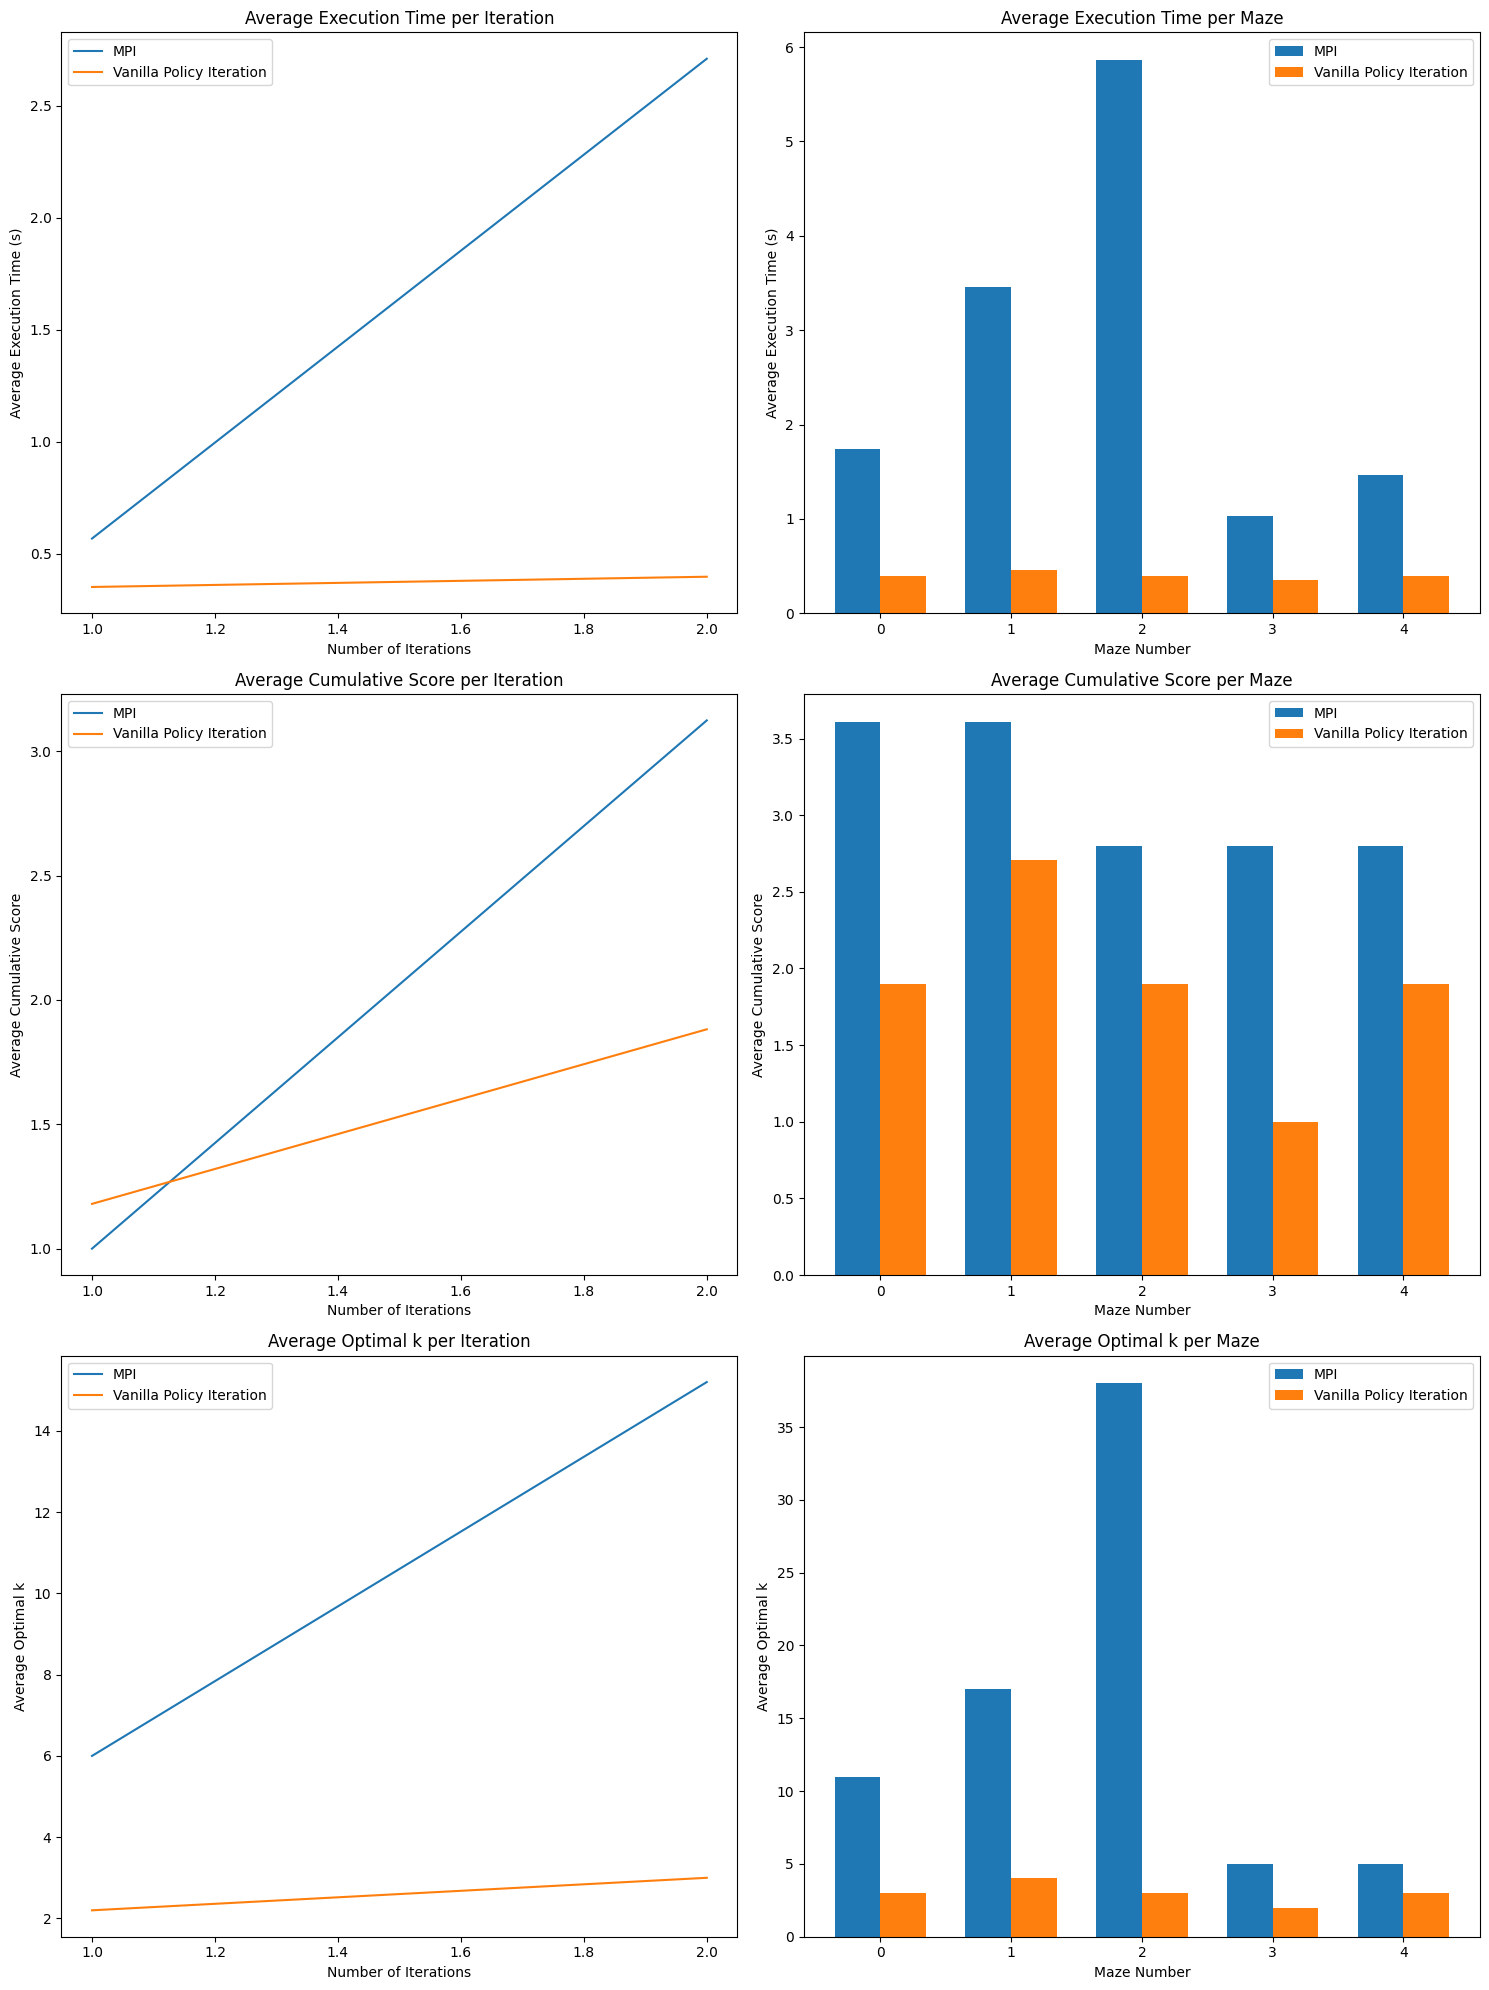

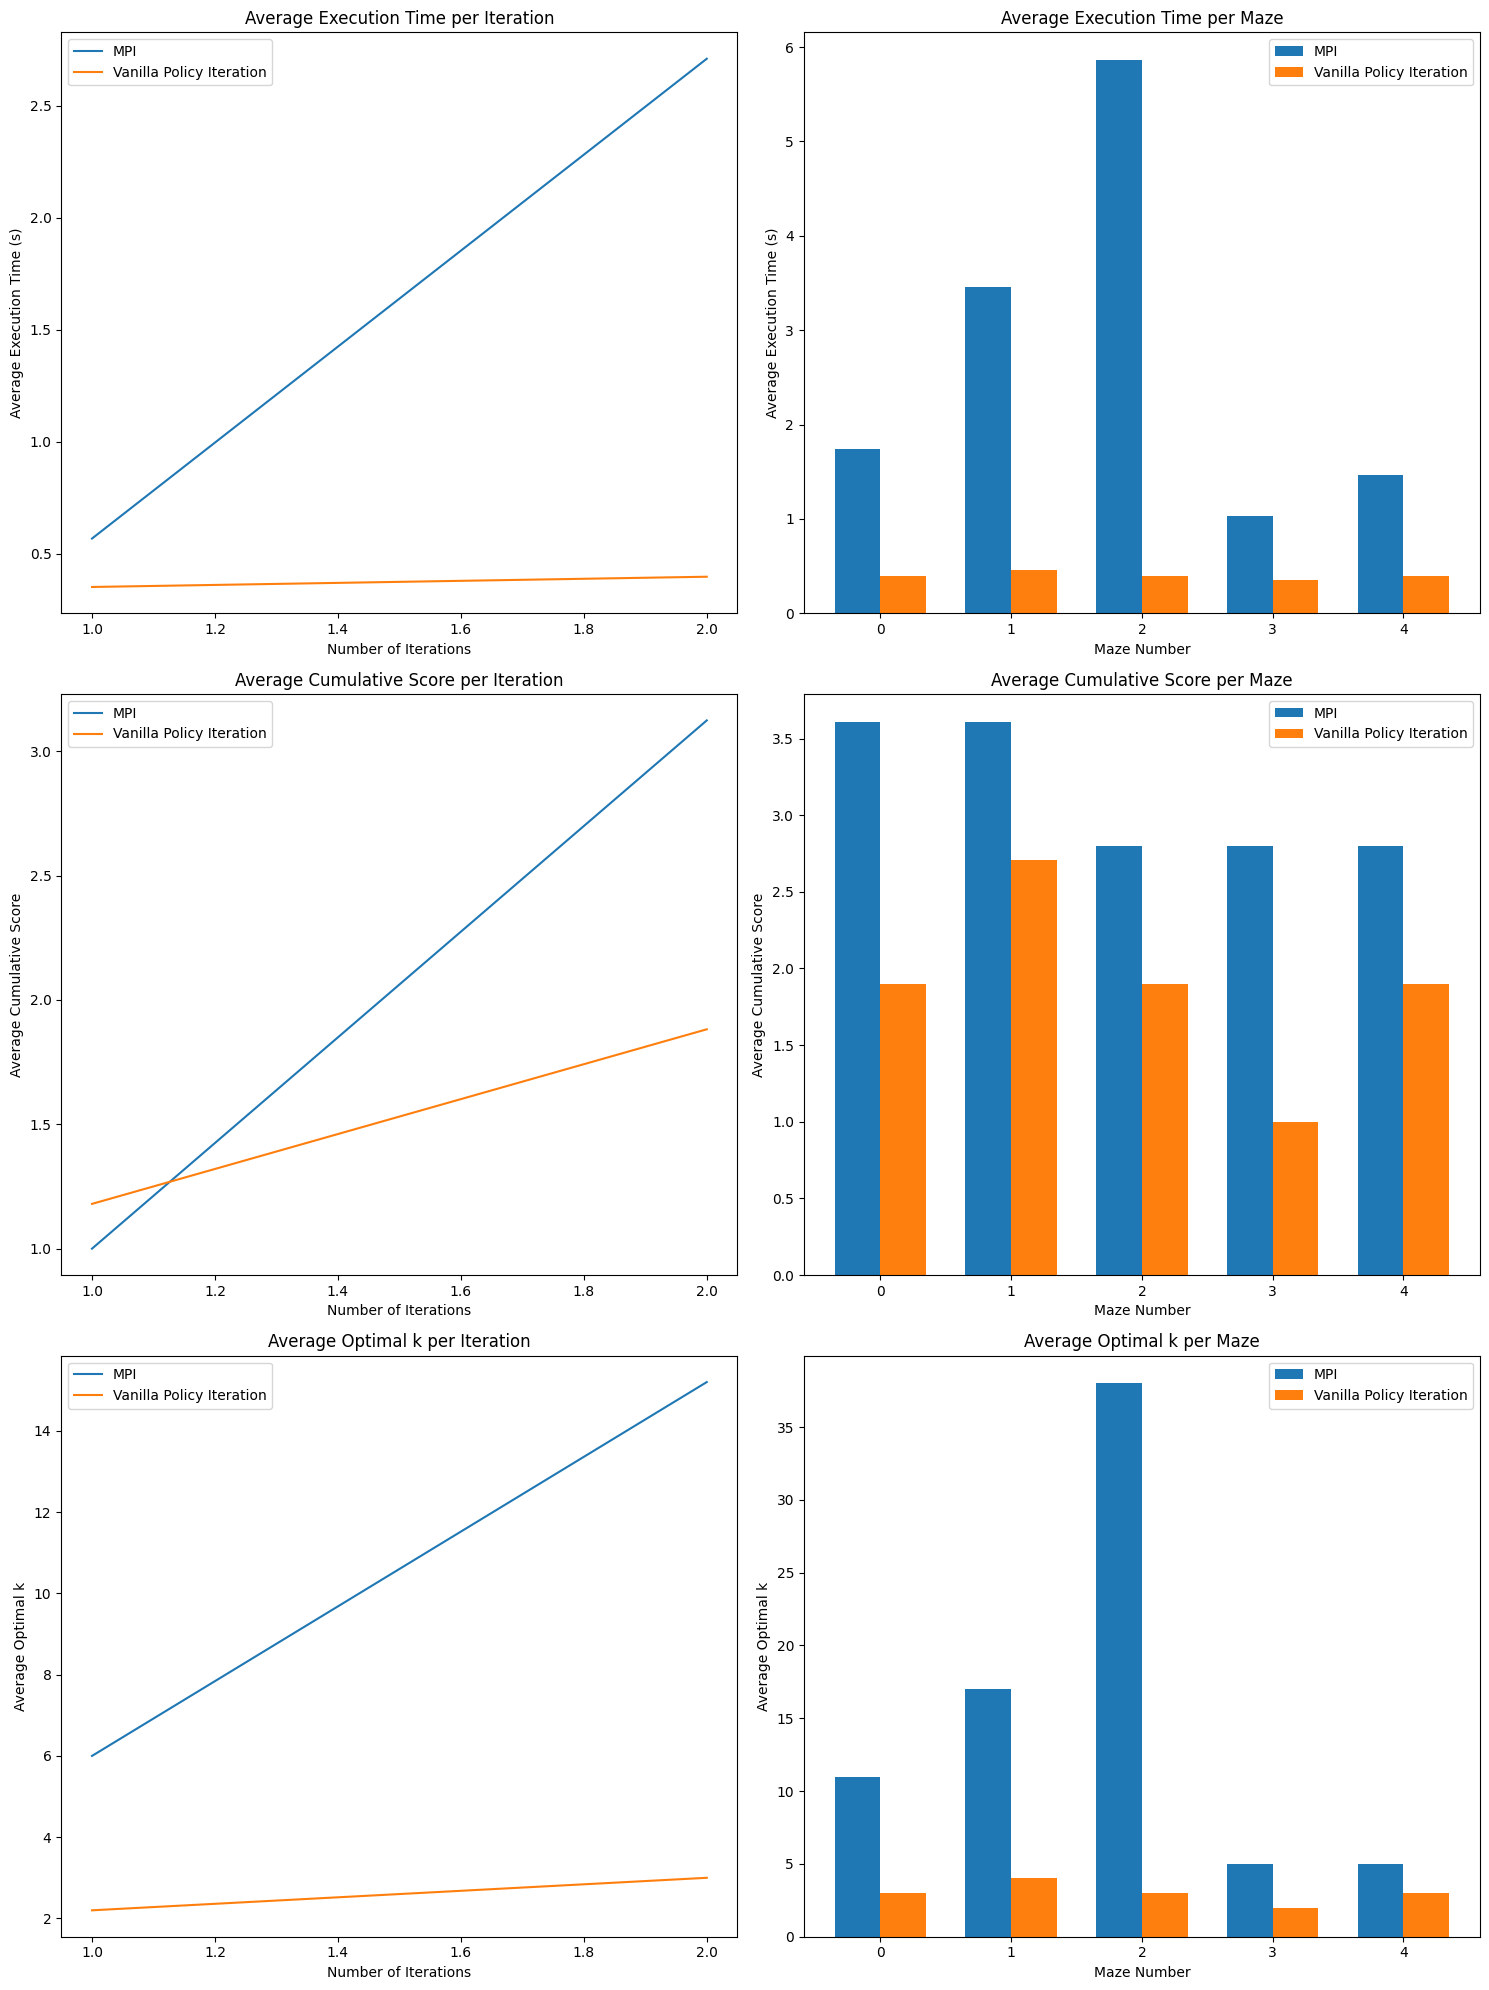

In [ ]:
import matplotlib.pyplot as plt

def visualize_empirical_study_updated(results_mpi, results_vanilla):
    fig, axs = plt.subplots(3, 2, figsize=(15, 20))

    # Extracting data for MPI and Vanilla Policy Iteration
    nb_iters = list(results_mpi['times_per_iter'][0].keys())

    # Function to aggregate data across all mazes for each number of iterations
    def aggregate_data(data_dict):
        return {nb_iter: [data_dict[nb_maze][nb_iter] for nb_maze in data_dict] for nb_iter in nb_iters}

    # Aggregating data for bar plots
    times_per_iter_mpi_agg = aggregate_data(results_mpi['times_per_iter'])
    times_per_iter_vanilla_agg = aggregate_data(results_vanilla['times_per_iter'])

    scores_mpi_agg = aggregate_data(results_mpi['scores'])
    scores_vanilla_agg = aggregate_data(results_vanilla['scores'])

    opt_k_mpi_agg = aggregate_data(results_mpi['opt_k'])
    opt_k_vanilla_agg = aggregate_data(results_vanilla['opt_k'])

    # Plotting curves
    # Execution Time
    axs[0, 0].plot(nb_iters, [sum(times_per_iter_mpi_agg[nb_iter]) / len(times_per_iter_mpi_agg[nb_iter]) for nb_iter in nb_iters], label='MPI')
    axs[0, 0].plot(nb_iters, [sum(times_per_iter_vanilla_agg[nb_iter]) / len(times_per_iter_vanilla_agg[nb_iter]) for nb_iter in nb_iters], label='Vanilla Policy Iteration')
    axs[0, 0].set_title('Average Execution Time per Iteration')
    axs[0, 0].set_xlabel('Number of Iterations')
    axs[0, 0].set_ylabel('Average Execution Time (s)')
    axs[0, 0].legend()

    # Cumulative Score
    axs[1, 0].plot(nb_iters, [sum(scores_mpi_agg[nb_iter]) / len(scores_mpi_agg[nb_iter]) for nb_iter in nb_iters], label='MPI')
    axs[1, 0].plot(nb_iters, [sum(scores_vanilla_agg[nb_iter]) / len(scores_vanilla_agg[nb_iter]) for nb_iter in nb_iters], label='Vanilla Policy Iteration')
    axs[1, 0].set_title('Average Cumulative Score per Iteration')
    axs[1, 0].set_xlabel('Number of Iterations')
    axs[1, 0].set_ylabel('Average Cumulative Score')
    axs[1, 0].legend()

    # Optimal k
    axs[2, 0].plot(nb_iters, [sum(opt_k_mpi_agg[nb_iter]) / len(opt_k_mpi_agg[nb_iter]) for nb_iter in nb_iters], label='MPI')
    axs[2, 0].plot(nb_iters, [sum(opt_k_vanilla_agg[nb_iter]) / len(opt_k_vanilla_agg[nb_iter]) for nb_iter in nb_iters], label='Vanilla Policy Iteration')
    axs[2, 0].set_title('Average Optimal k per Iteration')
    axs[2, 0].set_xlabel('Number of Iterations')
    axs[2, 0].set_ylabel('Average Optimal k')
    axs[2, 0].legend()

    # Bar plots
    # Getting the maze numbers
    maze_numbers = list(results_mpi['times_per_iter'].keys())

    # Adjusting the data aggregation to ensure consistent dimensions
    def adjusted_aggregate_data(data_dict, nb_mazes):
        return {nb_iter: [data_dict[nb_maze].get(nb_iter, 0) for nb_maze in range(nb_mazes)] for nb_iter in nb_iters}

    nb_mazes = len(maze_numbers)
    times_per_iter_mpi_agg = adjusted_aggregate_data(results_mpi['times_per_iter'], nb_mazes)
    times_per_iter_vanilla_agg = adjusted_aggregate_data(results_vanilla['times_per_iter'], nb_mazes)

    scores_mpi_agg = adjusted_aggregate_data(results_mpi['scores'], nb_mazes)
    scores_vanilla_agg = adjusted_aggregate_data(results_vanilla['scores'], nb_mazes)

    opt_k_mpi_agg = adjusted_aggregate_data(results_mpi['opt_k'], nb_mazes)
    opt_k_vanilla_agg = adjusted_aggregate_data(results_vanilla['opt_k'], nb_mazes)

    # Execution Time
    bar_width = 0.35  # the width of the bars
    x = np.arange(nb_mazes)  # the label locations
    axs[0, 1].bar(x - bar_width/2, times_per_iter_mpi_agg[nb_iters[-1]], bar_width, label='MPI')
    axs[0, 1].bar(x + bar_width/2, times_per_iter_vanilla_agg[nb_iters[-1]], bar_width, label='Vanilla Policy Iteration')
    axs[0, 1].set_title('Average Execution Time per Maze')
    axs[0, 1].set_xlabel('Maze Number')
    axs[0, 1].set_ylabel('Average Execution Time (s)')
    axs[0, 1].set_xticks(x)
    axs[0, 1].set_xticklabels(maze_numbers)
    axs[0, 1].legend()

    # Cumulative Score
    axs[1, 1].bar(x - bar_width/2, scores_mpi_agg[nb_iters[-1]], bar_width, label='MPI')
    axs[1, 1].bar(x + bar_width/2, scores_vanilla_agg[nb_iters[-1]], bar_width, label='Vanilla Policy Iteration')
    axs[1, 1].set_title('Average Cumulative Score per Maze')
    axs[1, 1].set_xlabel('Maze Number')
    axs[1, 1].set_ylabel('Average Cumulative Score')
    axs[1, 1].set_xticks(x)
    axs[1, 1].set_xticklabels(maze_numbers)
    axs[1, 1].legend()

    # Optimal k
    axs[2, 1].bar(x - bar_width/2, opt_k_mpi_agg[nb_iters[-1]], bar_width, label='MPI')
    axs[2, 1].bar(x + bar_width/2, opt_k_vanilla_agg[nb_iters[-1]], bar_width, label='Vanilla Policy Iteration')
    axs[2, 1].set_title('Average Optimal k per Maze')
    axs[2, 1].set_xlabel('Maze Number')
    axs[2, 1].set_ylabel('Average Optimal k')
    axs[2, 1].set_xticks(x)
    axs[2, 1].set_xticklabels(maze_numbers)
    axs[2, 1].legend()

    plt.tight_layout()
    return fig  # Returning the figure object

visualize_empirical_study_updated(results_mpi, results_vanilla)

In [ ]:
for maze in mazes:
    maze.init_draw("Maze")

  logger.warn(



Output()

Output()

Output()

Output()

Output()